# Прогнозирование временных рядов на карте. Интерактивная демонстрация

Ниже представлена интерактивная демонстрация результата проекта "Прогнозирование временных рядов на карте".

Интерактивные формы находятся в самом низу блокнота. В промежутке находятся служебные функции для обработки действий совершаемых в интерактивных формах.

## Код для подготовки к интерактивной работе

In [1]:
# Импортируем необходимые библиотеки
import pickle
from datetime import datetime as dttm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.patches import Polygon
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import os.path
from IPython.html.widgets import interact

Populating the interactive namespace from numpy and matplotlib


C:\Users\jjj\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



In [2]:
# К сожалению файлы с исходными данными и прогнозами занимают много места, поэтому
# для демонстрации выкладываю данные только для последнего месяца (2016-06), хотя 
# есть исходные данные и прогнозы для большего периода (с 2015-12)

# Загружаем подготовленные на первой неделе фактические данные
with open('rides_regions.p', "rb" ) as fr:
    rides_regions_data = pickle.load(fr)

# Загружаем прогнозы сделанные с помощью модели, разработанной на шестой неделе
with open('rides_regions_forecast.p', "rb" ) as fr:
    rides_regions_forecast_data = pickle.load(fr)

# Границы Нью-йорка
NY_west=-74.25559
NY_east=-73.70001
NY_south=40.49612
NY_north=40.91553

# Координаты Empire State Building
ESB_lon = [-73.985756,]
ESB_lat = [40.748306,]

# Справочник временных меток
dt_dict =[]
for x in pd.date_range( dttm.strptime('2016060100', '%Y%m%d%H'),dttm.strptime('2016063023', '%Y%m%d%H'),freq='H'):
    xx=dttm.strftime(x,'%Y%m%d%H')
    dt_dict.append(xx)
    
# Загружаем данные о регионах
regions = pd.read_csv('regions.csv', sep = ';')

In [3]:
# Функция для рисования прямоугольников на карте, разработанная на второй неделе
def draw_screen_poly( lats, lons, m,alpha_value):
    x, y = m( lons, lats )
    xy=[]
    for i in range(len(x)):
        xy.append([x[i],y[i]])
    poly = Polygon( xy, facecolor='red', alpha=alpha_value )
    plt.gca().add_patch(poly)

In [4]:
# Функция для отрисовки карт с фактическими и прогнозными значениями поездок на конкретную дату и в конкретный час
# Разработана на основе кода для отрисовки карт, который использовался на второй неделе.
def draw_map(Day, Hour):        
    #выбираем нужные данные
    hour_idx= dt_dict.index(Day+Hour) 
    rides_regions_forecast = rides_regions_forecast_data[hour_idx]
    rides_regions = rides_regions_data[hour_idx]

    # Рисуем график с фактическими данными
    # Инициализируем объект класса Basemap
    plt.subplot(121)    
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    plt.title("Fact")
    m = Basemap(projection='merc', resolution = 'h', 
                  llcrnrlon= NY_west, llcrnrlat= NY_south,
                  urcrnrlon= NY_east, urcrnrlat= NY_north)

    # Максимальное количество поездок за месяц
    max_rides = max(rides_regions)
    
    # Формируем изображения районов с раскраской соответственно интенсивности поездок
    for index, row in regions.iterrows():
        draw_screen_poly( [row.south, row.north, row.north ,row.south], [row.west, row.west,row.east,row.east], m, 1.0*rides_regions[index]/max_rides) 

    #Рисуем контуры побережий и Empire State Building
    m.drawcoastlines()
    x,y = m(ESB_lon, ESB_lat)
    m.plot(x, y, 'bo', markersize=6)
    
    
    # Рисуем график с прогнозными данными
    # Инициализируем объект класса Basemap
    plt.subplot(122)
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    plt.title("Forecast")
    m2 = Basemap(projection='merc', resolution = 'h', 
                  llcrnrlon= NY_west, llcrnrlat= NY_south,
                  urcrnrlon= NY_east, urcrnrlat= NY_north)
    
    # Максимальное количество поездок за месяц
    max_rides = max(rides_regions_forecast)
    
    # Формируем изображения районов с раскраской соответственно интенсивности поездок
    for index, row in regions.iterrows():
        draw_screen_poly([row.south, row.north, row.north ,row.south], [row.west, row.west,row.east,row.east], m2, 1.0*rides_regions_forecast[index]/max_rides) 
        
    #Рисуем контуры побережий и Empire State Building
    m2.drawcoastlines()
    m2.plot(x, y, 'bo', markersize=6)

In [6]:
# создаем справочники для дат и часов, которые будут использоваться в интерактивных формах
monthday_dt_dict ={}
for x in pd.date_range( dttm.strptime('20160601', '%Y%m%d'),dttm.strptime('20160630', '%Y%m%d'),freq='D'):
    xx=dttm.strftime(x,'%Y%m%d')
    monthday_dt_dict[xx]=xx
    
hour_dt_dict={}
for x in range(24):
    if x<10:
        hour_dt_dict['0'+str(x)]='0'+str(x)
    else:
        hour_dt_dict[str(x)]=str(x)

# создаем справочник регионов, который будет использоваться в интерактивных формах
region_dict={}
for x in range(2500):
    region_dict[str(x)]=x

In [7]:
# Функция для отрисовки временного ряда с фактическими и прогнозными значениями поездок 
# на конкретный временной диапазон для конкретного региона
def draw_ts(Day_begin, Day_end, Region):     
    #выбираем нужные данные
    idx_begin= dt_dict.index(Day_begin+'00')
    idx_end= dt_dict.index(Day_end+'23')
    
    if idx_begin>idx_end:
        print('Неправильно заданы начальная и конечные даты!')
        return
    
    rides_regions_forecast = [x[Region-1] for x in rides_regions_forecast_data][idx_begin:idx_end]
    rides_regions = [x[Region-1] for x in rides_regions_data][idx_begin:idx_end]
    time_labels = [dttm.strptime(x, '%Y%m%d%H') for x in dt_dict[idx_begin:idx_end]]
    
    rides_regions_ts = pd.Series(rides_regions, index=time_labels)
    rides_regions_forecast_ts = pd.Series(rides_regions_forecast, index=time_labels)

    # Рисуем график
    plt.figure(figsize(15,7))
    
    # рисуем фактические данные
    rides_regions_ts.plot()

    # рисуем прогноз
    rides_regions_forecast_ts.plot(color='r')

    plt.ylabel('Rides')
    plt.title('Factual and forecasted rides in region #'+str(Region))
    plt.legend(['Factual','Forecasted'])
    pylab.show()    

## Карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени

Необходимо выбрать момент времени (с точностью до часа) в форме ниже. После выбора момента времени отобразится карта с визуализацией реального и прогнозируемого спроса на такси в Нью-Йорке.

In [8]:
interact(draw_map, Day=monthday_dt_dict, Hour=hour_dt_dict);

A Jupyter Widget

Слева отображаются фактические данные о поездках. Справа - прогнозные.

Синей точной обозначено Empire State Building.

Красным цветом обозначена итенсивность поездок. Чем насышенее цвет, тем больше поездок.

## Временной ряд фактического и прогнозируемого спроса на такси в выбираемой области

Необходимо выбрать начало и конец временного периода, а также номер области в форме ниже. После выбора параметров отобразится график фактического и прогнозируемого спроса на такси.

In [9]:
interact(draw_ts, Day_begin=monthday_dt_dict, Day_end =monthday_dt_dict, Region=region_dict);

A Jupyter Widget

## Примеры для отрисовки в HTML формате
Добавляю эти примеры на случай если кому-то не удасться запустить мои интерактивные формы из-за проблем несовместимости питона или библиотек.

Примеры показывают типовой вывод интерактивных форм при вводе аналогичных параметров.

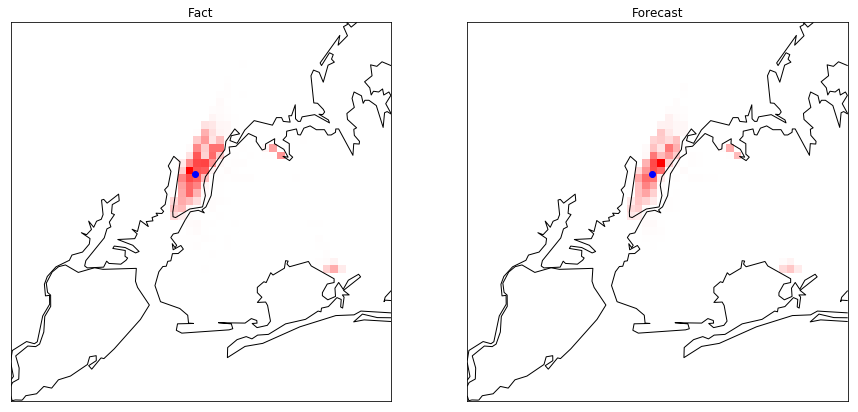

In [10]:
# Пример карт с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени
draw_map('20160612','15')

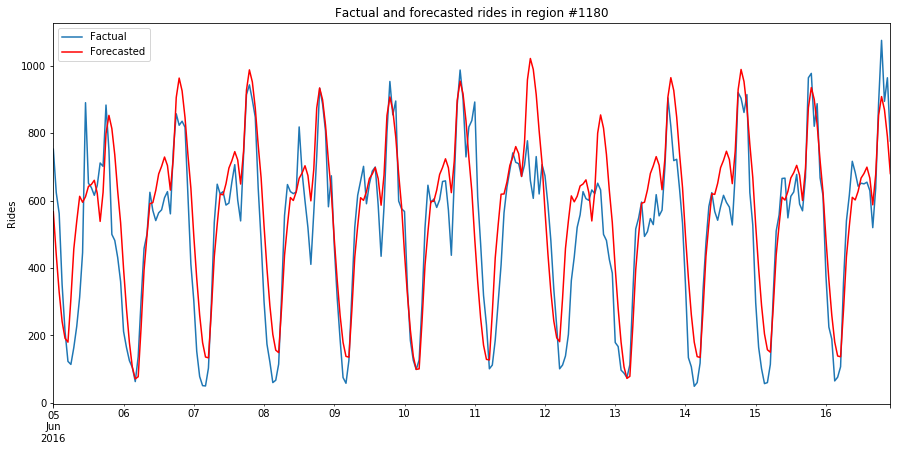

In [11]:
# Пример временных рядов фактического и прогнозируемого спроса на такси в выбираемой области

draw_ts('20160605','20160616',1180)